# Prep

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
from data_model import *
from data_helper import *
from config import *
setup()

F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


Config finished!


In [2]:
Constants.__dict__.keys()

dict_keys(['__module__', 'LEAGUES', 'DATA_PATH', 'REDUCED', 'INTERESTING_CURRENCIES', 'IMG_OUTPUT_PATH', 'DPI_OUTPUT', 'SAMPLE_LEAGUE_NAME', '__dict__', '__weakref__', '__doc__'])

# Load

In [3]:
print('default: ', Constants.DATA_PATH)
Constants.DATA_PATH = '../data'
print('changed: ', Constants.DATA_PATH)

default:  ./data
changed:  ../data


In [4]:
DATA = DataHelper.load_all_leagues_data(Constants.DATA_PATH, Constants.LEAGUES)

Loading League Data, league: Essence
Load POE DATA, league specific name: Essence, type: Event
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore Essence, type: Event Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore, type: Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Standard, type: Standard
Reading currency!
Reading items!
Loading League Data, league: Breach
Load POE DATA, league specific name: Breach, type: Event
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore Breach, type: Event Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Hardcore, type: Hardcore
Reading currency!
Reading items!
Load POE DATA, league specific name: Standard, type: Standard
Reading currency!
Reading items!
Loading League Data, league: Legacy
Load POE DATA, league specific name: Legacy, type: Event
Reading currency!
Reading items!
Load POE DATA, league s

# Helpers

### Data Getter

In [17]:
output_path = './output'
DPI_OUTPUT = 300

def get_data(name):
    return DataHelper.get_concatinated_currency_data(name, DATA)
def plot_all(data, name):
    figure = plt.figure(figsize=(20,10))
    ax = figure.add_subplot(1,1,1)
    sns.lineplot(data=data,x='Date', y='Value', hue='League')

    ylim_low, ylim_high = ax.get_ylim()
    plot_name = f'{name}_all_leagues_value'
    plt.title(plot_name)
    plt.savefig(f'{output_path}/{plot_name}.png', dpi = DPI_OUTPUT)
    plt.show()

### Processing

In [14]:
from sklearn.preprocessing import LabelEncoder

def process(df, name):
    # quick check pay
    pay_currencies = df['Pay'].unique()
    if len(pay_currencies) != 1 and pay_currencies[0] != 'Chaos Orb': raise TypeError('Pay Currency is not Chaos Orb (medium)')
    
    # quick check get
    get_currencies = df['Get'].unique()
    if len(get_currencies) != 1 and get_currencies[0] != name: raise TypeError('Pay Currency is not Chaos Orb (medium)')

    #engineering
    selected_features = [
        'Date',
        'Value',
        'League', # this could (or not) be useful, but i decide to just keep it
    ]
    df_return = df[selected_features].copy()

    enc = LabelEncoder()
    df_return['Confidence'] = enc.fit_transform(df['Confidence'])
    # mapping = dict(zip(enc.classes_,enc.transform(enc.classes_)))
    # print('Transformed confidence mapping: ', mapping)
    df_return.index = pd.to_datetime(df_return['Date'])
    if df_return.isna().sum(axis=0).sum() != 0:
        raise TypeError('Nul value detected after processing')
    return df_return

### Engineering

In [7]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
def make_multi_target(ts, steps, lead_time=1):
    return pd.concat(
        {
            f'y_step_{i}': ts.shift(-i)
            for i in range(lead_time, steps + lead_time)
        },
        axis=1)

class FeatureEngineer:
    def target(self, df, steps = 5):
        return pd.concat([
            make_multi_target(df['Value'], steps).fillna(0),
            df[['League']]
        ], axis = 1)
    
    def time_features(self, df):
        df_return = pd.DataFrame()
        df_return['LeagueDay'] = (df.groupby('League').cumcount() + 1).astype(np.float64)
        time_index = df.index


        df_return['day_of_week'] = time_index.dayofweek
        df_return['month'] = time_index.month

        return df_return

    def lag_features(self, df, lags = 4):
        return make_lags(df['Value'], lags).fillna(0)

    def rolling_features(self, df, local_window_size = 5, general_window_size=15):
        local_rolling = df['Value'].rolling(local_window_size, center = True)
        general_rolling = df['Value'].rolling(general_window_size, center = True)

        df_return = pd.DataFrame()
        df_return['rolling_mean'] = local_rolling.mean()
        df_return['rolling_min'] = local_rolling.min()
        df_return['rolling_max'] = local_rolling.max()
        df_return['general_rolling_mean'] = general_rolling.mean()
        df_return['general_rolling_min'] = general_rolling.min()
        df_return['general_rolling_max'] = general_rolling.max()
        return df_return        
    
    def expanded_features(self, df, min_period = 2):
        expanding = df['Value'].expanding(min_period, center = True)
        pd_return = pd.DataFrame()
        pd_return['expanding_mean'] = expanding.mean()
        pd_return['expanding_max'] = expanding.max()
        pd_return['expanding_min'] = expanding.min()
        return pd_return

    def all_features(self, df, fill0 = True):
        df_return =  pd.concat(
            [
                self.time_features(df),
                self.lag_features(df),
                self.rolling_features(df),
                self.expanded_features(df),
                df[['League']]
            ],
            
            axis = 1
        )
        return df_return.fillna(0) if fill0 else df_return

def engineer(feature_engineer, data):
    X = feature_engineer.all_features(data)
    y = feature_engineer.target(data)

    return X, y

### Split

In [8]:
def train_val_split(df):
    is_last_league = df['League'] == Constants.LEAGUES[-1]

    df_train = df[~is_last_league].drop('League', axis = 1)
    df_val = df[is_last_league].drop('League', axis = 1)
    return df_train, df_val
def print_train_val_stats(train,val):
    print('shapes: ', train.shape, val.shape)
    display(train.head(2))
    display(val.head(2))

def split(X,y):
    X_train, X_val = train_val_split(X)
    y_train, y_val = train_val_split(y)

    print_train_val_stats(X_train, X_val)
    print_train_val_stats(y_train, y_val)

    return X_train, X_val, y_train, y_val

### Save

In [9]:
def save(X_train, X_val, y_train, y_val, item_name):
    out_names = ['X_train', 'X_val', 'y_train', 'y_val']
    outs_dfs = [X_train, X_val, y_train, y_val]
    for name, df in zip(out_names, outs_dfs):
        out_name = f'./data/{item_name}.{name}.csv'
        print(f'Saving {out_name}')
        df.reset_index().to_csv(out_name, index=False)

# Processing Pipeline

In [15]:
fe = FeatureEngineer()
def processing_pipeline(name):
    data = get_data(name)
    plot_all(data,name)
    
    processed = process(data,name)
    X, y = engineer(fe, processed)

    X_train, X_val, y_train, y_val = split(X,y)
    save(X_train, X_val, y_train, y_val, name)

# Let's Run

In [24]:
choosen_currency = {
    'dirt' : ["Armourer's Scrap", "Orb of Alteration", "Chromatic Orb", "Regal Orb"],
    'low' : ["Vaal Orb", "Splinter of Chayula", "Prime Sextant"],
    'medium' : ["Divine Orb", "Xoph's Breachstone", "Mortal Ignorance"],
    'high' : ["Chayula's Breachstone", "Blessing of Chayula"]
}

### Dirt Type

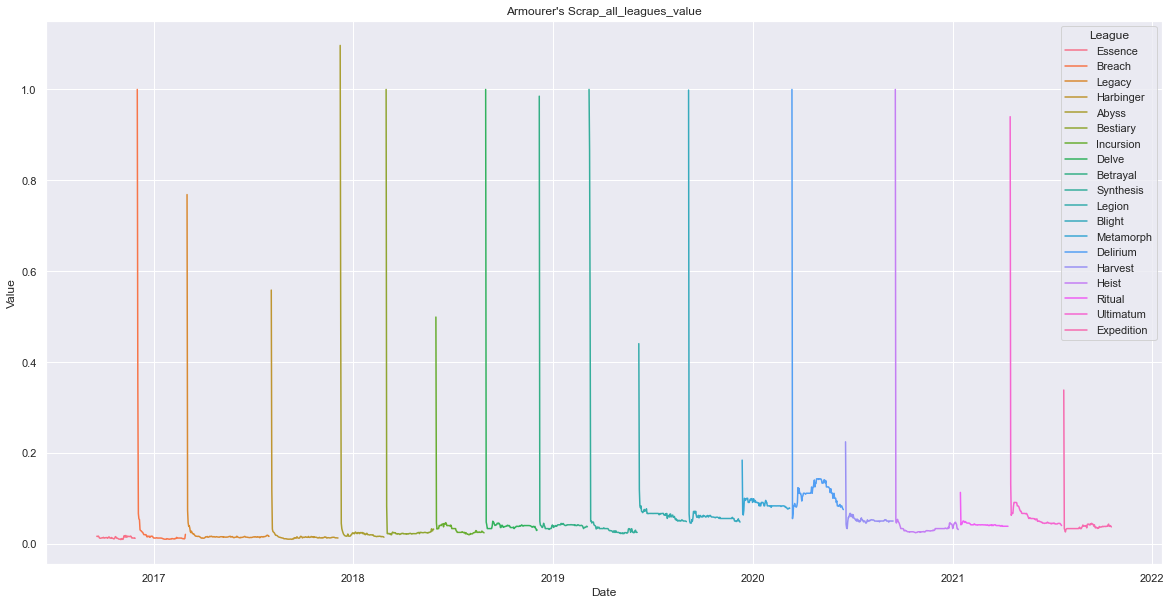

shapes:  (1713, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-19,1.0,0,9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000
2016-09-20,2.0,1,9,0.01652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016175,0.01652,0.01583


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,0.04000,0.04167,0.04348,0.04481,0.09666,0.03009,0.33834,0.057511,0.02592,0.33834,0.048776,1.09689,0.00911
2021-07-24,2.0,5,7,0.33834,0.04000,0.04167,0.04348,0.09351,0.02592,0.33834,0.056750,0.02592,0.33834,0.048767,1.09689,0.00911


shapes:  (1713, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-19,0.01583,0.01643,0.01667,0.01461,0.01249
2016-09-20,0.01643,0.01667,0.01461,0.01249,0.01218


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,0.03320,0.03009,0.02592,0.03153,0.03277
2021-07-24,0.03009,0.02592,0.03153,0.03277,0.03333


Saving ./data/Armourer's Scrap.X_train.csv
Saving ./data/Armourer's Scrap.X_val.csv
Saving ./data/Armourer's Scrap.y_train.csv
Saving ./data/Armourer's Scrap.y_val.csv


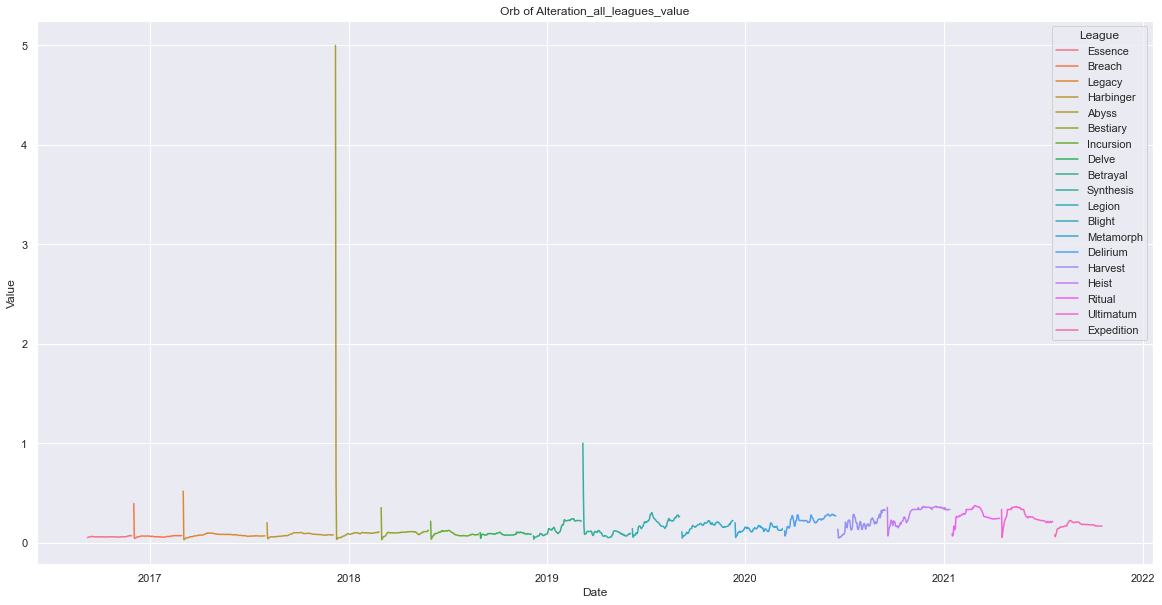

shapes:  (1724, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00
2016-09-09,2.0,4,9,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05163,0.05326,0.05


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,0.21268,0.21240,0.20285,0.20758,0.129044,0.05882,0.21268,0.155083,0.05882,0.21438,0.149748,5.0,0.03055
2021-07-24,2.0,5,7,0.07799,0.21268,0.21240,0.20285,0.106298,0.05882,0.21268,0.151080,0.05882,0.21438,0.149695,5.0,0.03055


shapes:  (1724, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,0.05326,0.05645,0.05727,0.05637,0.05674
2016-09-09,0.05645,0.05727,0.05637,0.05674,0.05916


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,0.05882,0.08333,0.09867,0.12613,0.13862
2021-07-24,0.08333,0.09867,0.12613,0.13862,0.14286


Saving ./data/Orb of Alteration.X_train.csv
Saving ./data/Orb of Alteration.X_val.csv
Saving ./data/Orb of Alteration.y_train.csv
Saving ./data/Orb of Alteration.y_val.csv


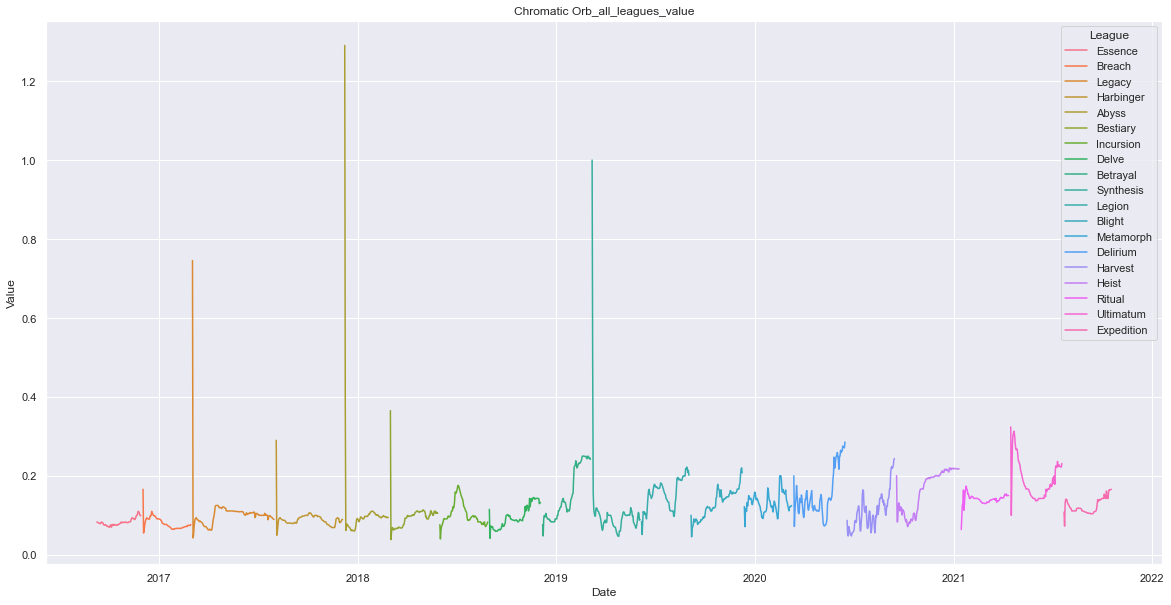

shapes:  (1724, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000
2016-09-09,2.0,4,9,0.08306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082645,0.08306,0.08223


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,0.23131,0.22222,0.22284,0.22338,0.152814,0.07266,0.23131,0.171378,0.07266,0.23131,0.121963,1.29067,0.03846
2021-07-24,2.0,5,7,0.10789,0.23131,0.22222,0.22284,0.136442,0.07266,0.23131,0.164847,0.07266,0.23131,0.121935,1.29067,0.03846


shapes:  (1724, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,0.08223,0.08143,0.08148,0.08036,0.07952
2016-09-09,0.08143,0.08148,0.08036,0.07952,0.07870


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,0.07266,0.12999,0.14036,0.14085,0.13997
2021-07-24,0.12999,0.14036,0.14085,0.13997,0.13333


Saving ./data/Chromatic Orb.X_train.csv
Saving ./data/Chromatic Orb.X_val.csv
Saving ./data/Chromatic Orb.y_train.csv
Saving ./data/Chromatic Orb.y_val.csv


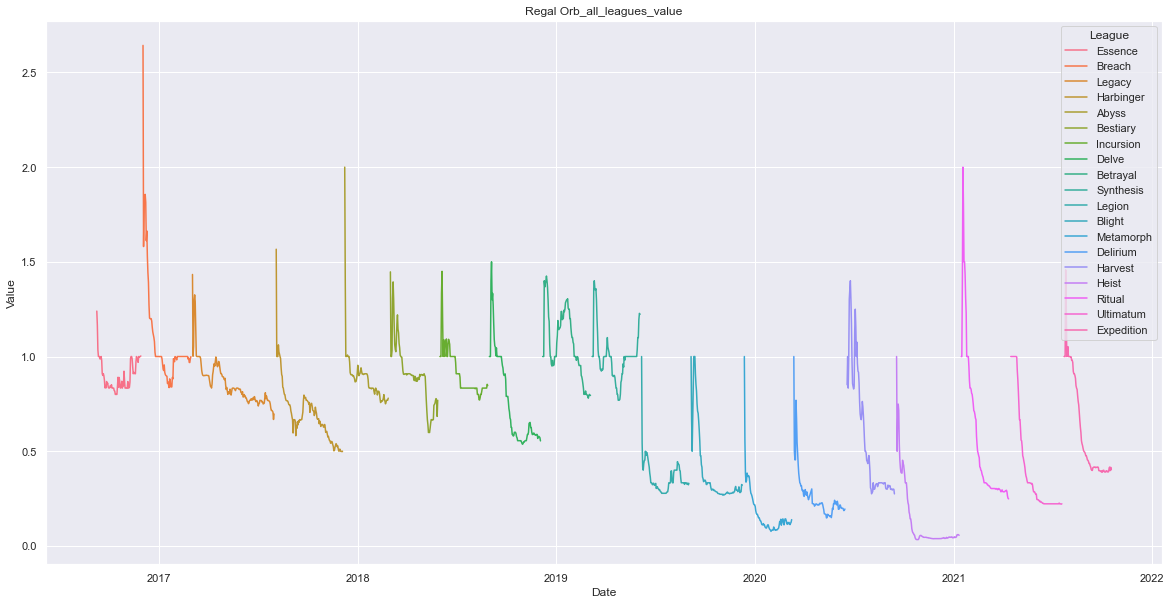

shapes:  (1724, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000
2016-09-09,2.0,4,9,1.23985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.20287,1.23985,1.16589


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,0.22222,0.22056,0.22126,0.22222,0.688556,0.22056,1.00000,0.691575,0.22056,1.45756,0.656565,2.64286,0.03333
2021-07-24,2.0,5,7,1.00000,0.22222,0.22056,0.22126,0.935956,0.22222,1.45756,0.743427,0.22056,1.45756,0.656764,2.64286,0.03333


shapes:  (1724, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,1.16589,1.03485,1.0,1.0,1.00000
2016-09-09,1.03485,1.00000,1.0,1.0,0.98696


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,1.0,1.00000,1.45756,1.28444,1.00000
2021-07-24,1.0,1.45756,1.28444,1.00000,1.02226


Saving ./data/Regal Orb.X_train.csv
Saving ./data/Regal Orb.X_val.csv
Saving ./data/Regal Orb.y_train.csv
Saving ./data/Regal Orb.y_val.csv


In [20]:
for currency_name in choosen_currency['dirt']:
    processing_pipeline(currency_name)

### Low Type

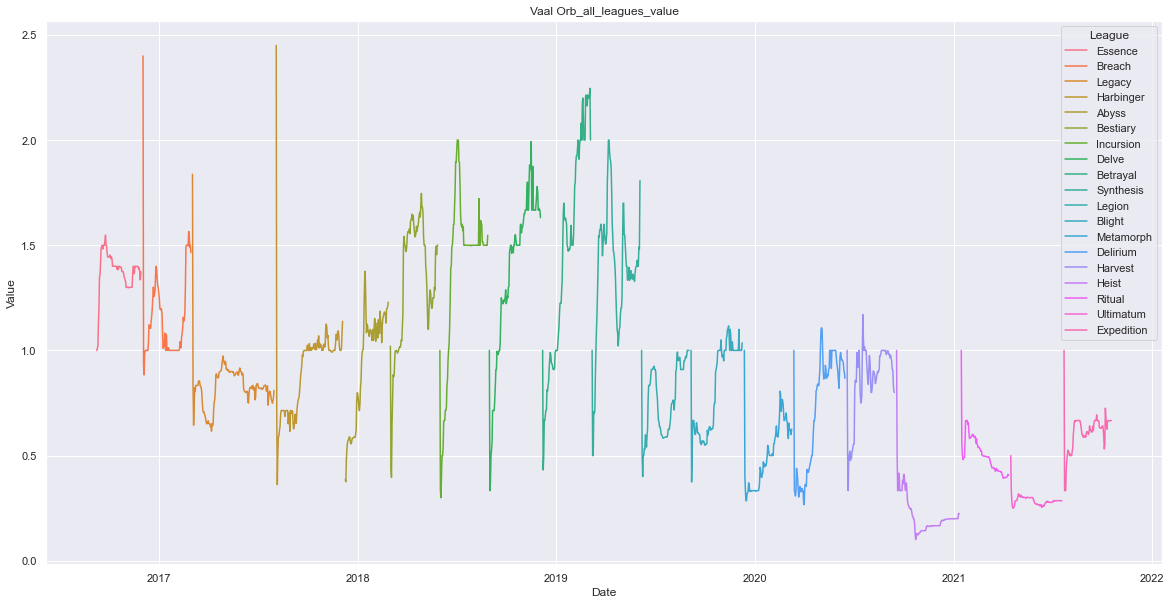

shapes:  (1723, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0
2016-09-09,2.0,4,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.004955,1.00991,1.0


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,0.28571,0.28571,0.28571,0.28571,0.447616,0.28571,1.0,0.395200,0.28571,1.0,0.918632,2.45,0.10065
2021-07-24,2.0,5,7,1.00000,0.28571,0.28571,0.28571,0.457140,0.28571,1.0,0.410969,0.28571,1.0,0.918293,2.45,0.10065


shapes:  (1723, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,1.00991,1.01950,1.12429,1.21554,1.35317
2016-09-09,1.01950,1.12429,1.21554,1.35317,1.35786


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,0.33333,0.33333,0.33333,0.42784,0.47388
2021-07-24,0.33333,0.33333,0.42784,0.47388,0.50000


Saving ./data/Vaal Orb.X_train.csv
Saving ./data/Vaal Orb.X_val.csv
Saving ./data/Vaal Orb.y_train.csv
Saving ./data/Vaal Orb.y_val.csv


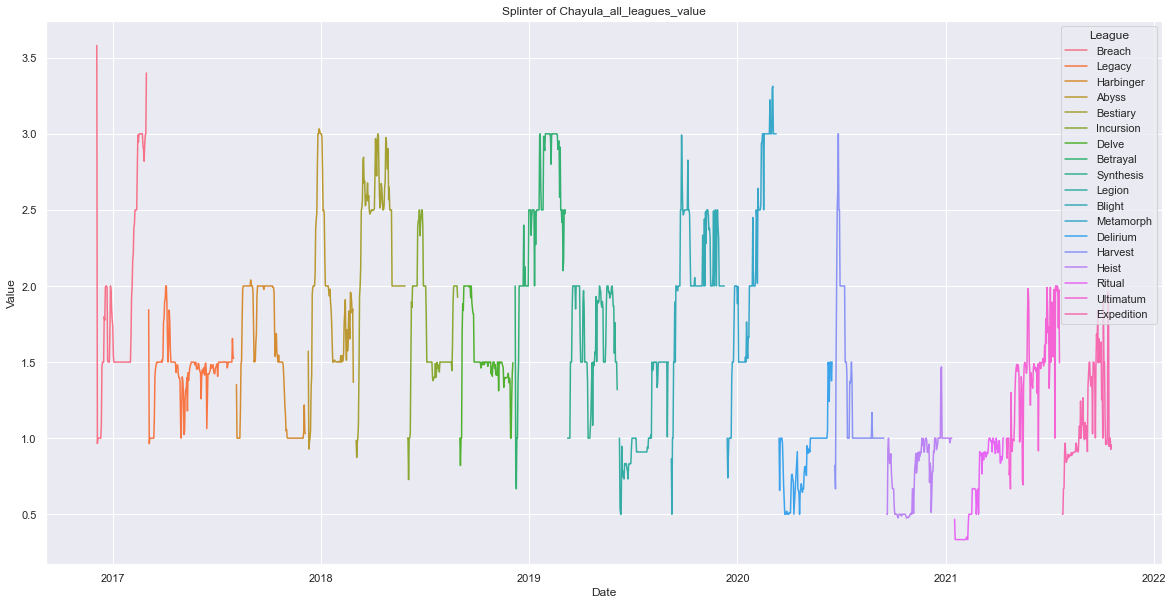

shapes:  (1627, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-12-03,1.0,5,12,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000
2016-12-04,2.0,6,12,3.58095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.273065,3.58095,0.96518


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,1.4954,1.97414,1.72475,1.99305,1.027242,0.5,1.97414,1.273924,0.5,2.0,1.560966,3.58095,0.33333
2021-07-25,2.0,6,7,0.5000,1.49540,1.97414,1.72475,0.766704,0.5,1.49540,1.197733,0.5,2.0,1.560314,3.58095,0.33333


shapes:  (1627, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-12-03,0.96518,1.00000,0.99887,1.0,1.0
2016-12-04,1.00000,0.99887,1.00000,1.0,1.0


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,0.50000,0.66667,0.67145,0.91097,0.96766
2021-07-25,0.66667,0.67145,0.91097,0.96766,0.89621


Saving ./data/Splinter of Chayula.X_train.csv
Saving ./data/Splinter of Chayula.X_val.csv
Saving ./data/Splinter of Chayula.y_train.csv
Saving ./data/Splinter of Chayula.y_val.csv


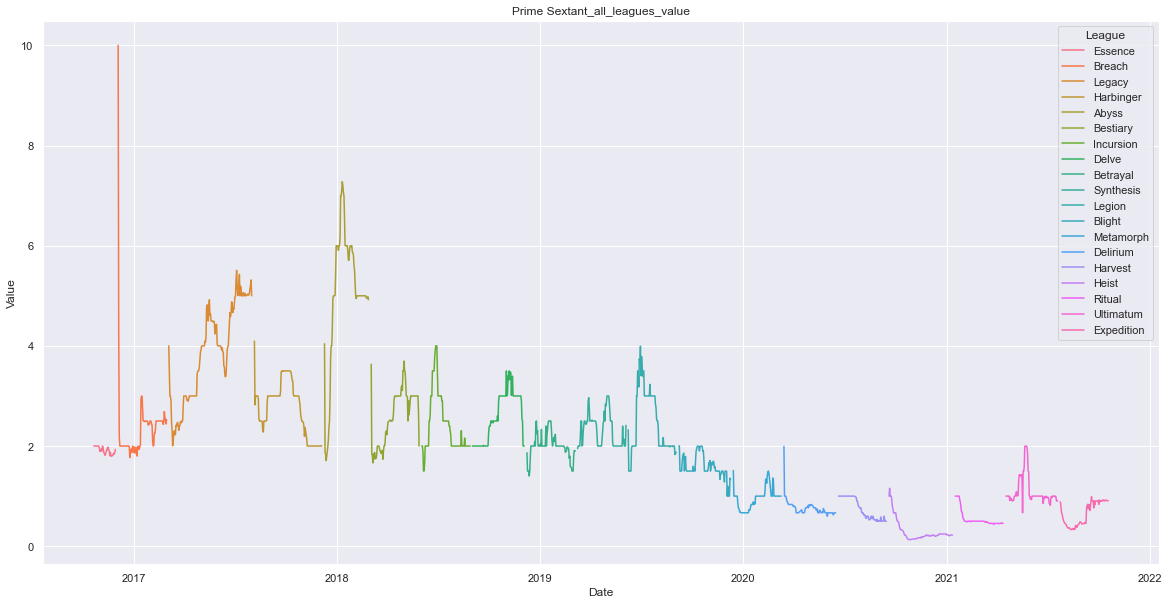

shapes:  (1665, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-10-20,1.0,3,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10-21,2.0,4,10,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,0.90646,0.90202,0.90425,0.98696,0.83195,0.66667,0.90646,0.786171,0.47572,1.0,2.062478,10.0,0.13171
2021-07-25,2.0,6,7,0.88460,0.90646,0.90202,0.90425,0.78188,0.65167,0.90646,0.749807,0.45455,1.0,2.061721,10.0,0.13171


shapes:  (1665, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-10-20,2.0,2.0,2.0,2.0,2.0
2016-10-21,2.0,2.0,2.0,2.0,2.0


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,0.80000,0.66667,0.65167,0.58672,0.54021
2021-07-25,0.66667,0.65167,0.58672,0.54021,0.49879


Saving ./data/Prime Sextant.X_train.csv
Saving ./data/Prime Sextant.X_val.csv
Saving ./data/Prime Sextant.y_train.csv
Saving ./data/Prime Sextant.y_val.csv


In [21]:
for currency_name in choosen_currency['low']:
    processing_pipeline(currency_name)

### Med Type

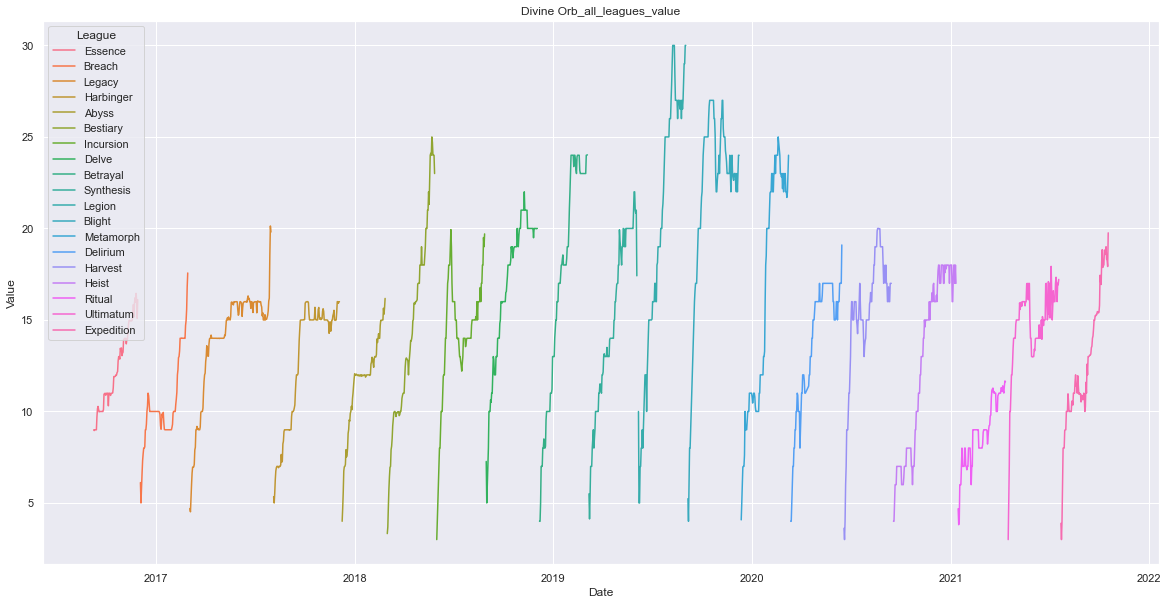

shapes:  (1719, 16) (88, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.00000
2016-09-09,2.0,4,9,8.99146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.9742,8.99146,8.95694


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-23,1.0,4,7,17.21454,16.92034,17.00000,16.0,9.004754,3.0,17.21454,11.221599,3.0,17.33347,14.515049,30.0,3.0
2021-07-24,2.0,5,7,3.88889,17.21454,16.92034,17.0,6.820686,3.0,17.21454,10.688266,3.0,17.33347,14.508358,30.0,3.0


shapes:  (1719, 5) (88, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-08,8.95694,8.99431,8.99817,9.0,9.0000
2016-09-09,8.99431,8.99817,9.00000,9.0,9.7049


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-23,3.0,4.0,6.0,8.0,8.0
2021-07-24,4.0,6.0,8.0,8.0,8.0


Saving ./data/Divine Orb.X_train.csv
Saving ./data/Divine Orb.X_val.csv
Saving ./data/Divine Orb.y_train.csv
Saving ./data/Divine Orb.y_val.csv


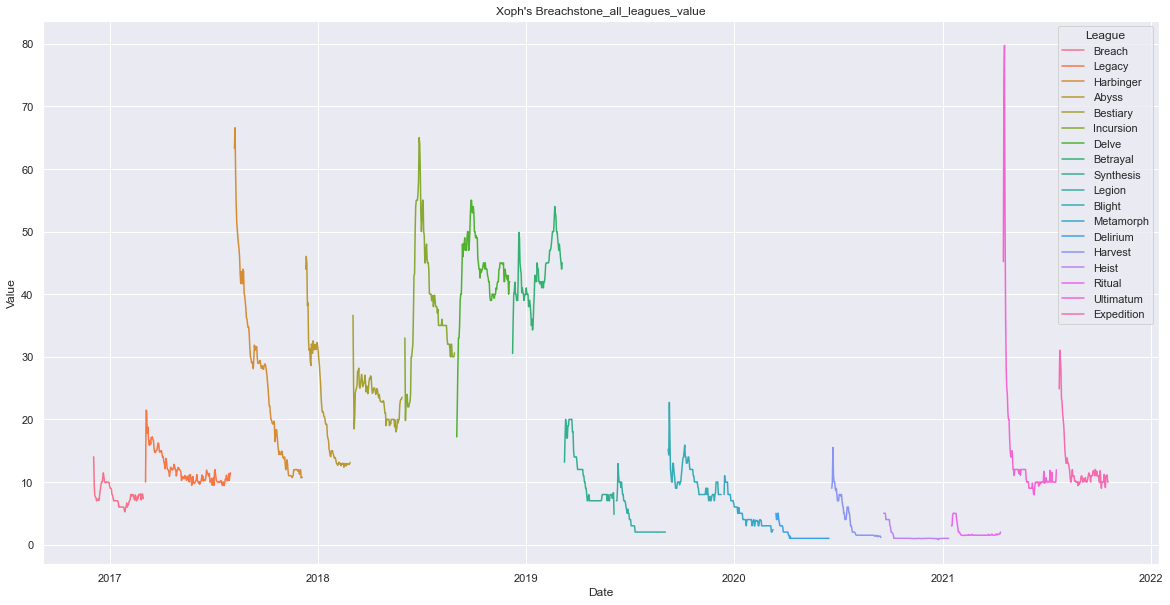

shapes:  (1622, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-12-03,1.0,5,12,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000
2016-12-04,2.0,6,12,14.02143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.72168,14.02143,9.42193


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,11.94898,10.00000,9.94737,10.00000,21.531182,10.00000,31.04773,18.183193,9.94737,31.04773,15.573145,79.73512,0.8
2021-07-25,2.0,6,7,24.87000,11.94898,10.00000,9.94737,25.131182,11.94898,31.04773,18.783193,9.94737,31.04773,15.582674,79.73512,0.8


shapes:  (1622, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-12-03,9.42193,7.80714,7.61610,7.47232,7.00000
2016-12-04,7.80714,7.61610,7.47232,7.00000,7.21964


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,31.04773,29.7892,28.00000,23.34728,22.79734
2021-07-25,29.78920,28.0000,23.34728,22.79734,21.00000


Saving ./data/Xoph's Breachstone.X_train.csv
Saving ./data/Xoph's Breachstone.X_val.csv
Saving ./data/Xoph's Breachstone.y_train.csv
Saving ./data/Xoph's Breachstone.y_val.csv


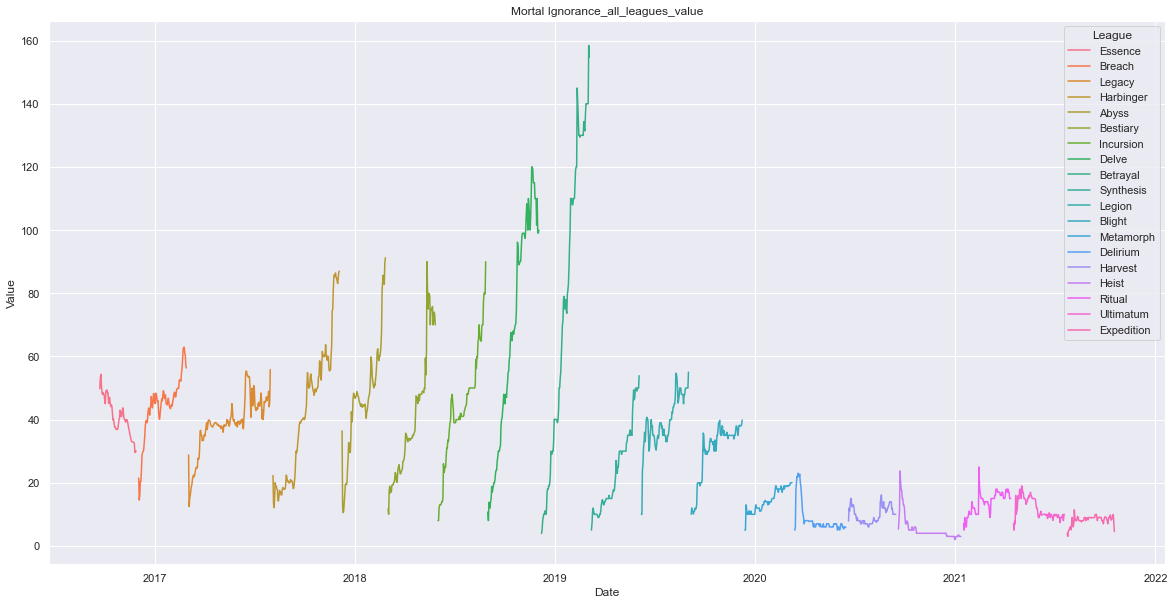

shapes:  (1692, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-23,1.0,4,9,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,0.00000
2016-09-24,2.0,5,9,49.77788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.48859,53.1993,49.77788


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,9.94286,9.75556,8.00000,10.0,6.271048,3.0,9.94286,6.921002,3.0,10.0,33.254547,158.48404,2.0
2021-07-25,2.0,6,7,4.00000,9.94286,9.75556,8.0,5.319936,3.0,9.94286,6.785461,3.0,10.0,33.236688,158.48404,2.0


shapes:  (1692, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-09-23,53.1993,54.32500,50.63056,48.49132,47.95775
2016-09-24,54.3250,50.63056,48.49132,47.95775,48.52394


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,3.00000,4.65682,5.0,5.00000,5.85119
2021-07-25,4.65682,5.00000,5.0,5.85119,6.00000


Saving ./data/Mortal Ignorance.X_train.csv
Saving ./data/Mortal Ignorance.X_val.csv
Saving ./data/Mortal Ignorance.y_train.csv
Saving ./data/Mortal Ignorance.y_val.csv


In [22]:
for currency_name in choosen_currency['medium']:
    processing_pipeline(currency_name)

### High Type

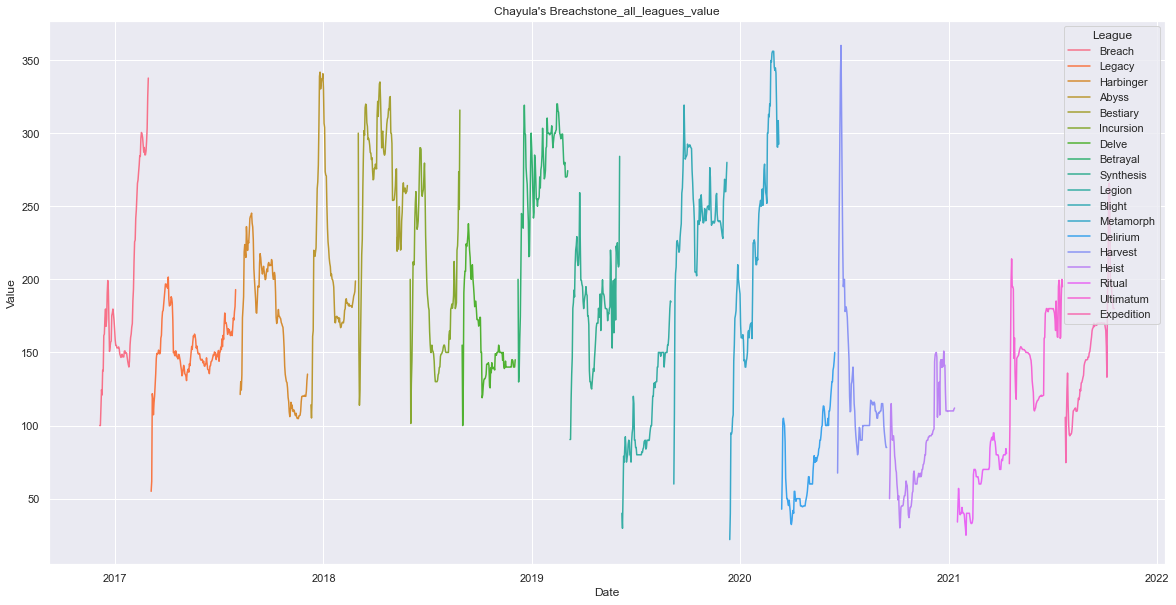

shapes:  (1617, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-12-05,1.0,0,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-06,2.0,1,12,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,100.0


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,195.00000,200.0,188.38158,160.38704,136.052462,74.61231,200.0,143.432869,74.61231,200.0,167.711539,360.0,22.0
2021-07-25,2.0,6,7,105.63333,195.0,200.00000,188.38158,121.038010,74.61231,195.0,136.336960,74.61231,200.0,167.654035,360.0,22.0


shapes:  (1617, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-12-05,100.0,124.50000,120.89286,137.80741,137.36909
2016-12-06,124.5,120.89286,137.80741,137.36909,161.53818


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,74.61231,105.01667,124.92774,135.90625,114.0000
2021-07-25,105.01667,124.92774,135.90625,114.00000,100.1791


Saving ./data/Chayula's Breachstone.X_train.csv
Saving ./data/Chayula's Breachstone.X_val.csv
Saving ./data/Chayula's Breachstone.y_train.csv
Saving ./data/Chayula's Breachstone.y_val.csv


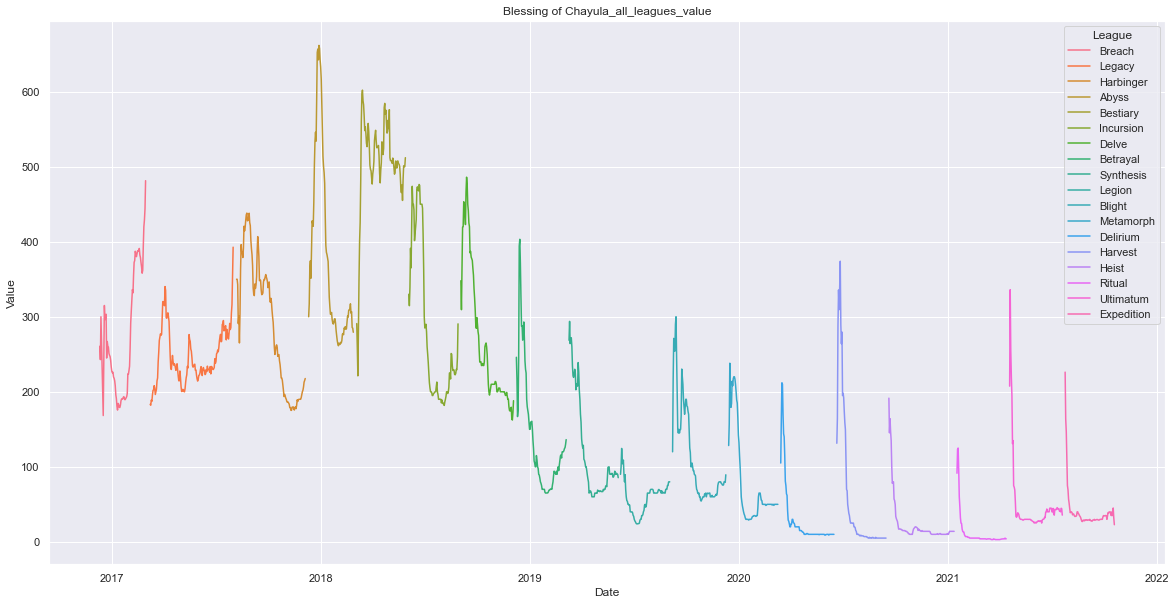

shapes:  (1603, 16) (87, 16)


F:\AppSSD\WorkTools\Anaconda\envs\gpu-ML\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The `center` argument on `expanding` will be removed in the future


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-12-10,1.0,5,12,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.00000
2016-12-11,2.0,6,12,260.65385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251.7488,260.65385,242.84375


,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2021-07-24,1.0,5,7,35.6250,44.17647,44.78947,40.00000,123.274976,35.625,226.1875,79.431257,35.625,226.1875,172.048779,661.62653,3.0
2021-07-25,2.0,6,7,226.1875,35.62500,44.17647,44.78947,136.639682,35.625,226.1875,79.428725,35.625,226.1875,172.043581,661.62653,3.0


shapes:  (1603, 5) (87, 5)


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2016-12-10,242.84375,300.00000,168.33333,315.00,296.02000
2016-12-11,300.00000,168.33333,315.00000,296.02,298.80577


,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5
Date,,,,,
2021-07-24,163.70734,146.67857,111.0,75.00000,69.43541
2021-07-25,146.67857,111.00000,75.0,69.43541,56.95139


Saving ./data/Blessing of Chayula.X_train.csv
Saving ./data/Blessing of Chayula.X_val.csv
Saving ./data/Blessing of Chayula.y_train.csv
Saving ./data/Blessing of Chayula.y_val.csv


In [25]:
for currency_name in choosen_currency['high']:
    processing_pipeline(currency_name)